## **Overview**

Our project is focused on building a pipeline for a household object locator. The pipeline will use our voice as input and process the object that we want to detect. Then we will use object localization and detection to search for the object in question using image feed from a camera. We will then use an LLM to process the outputs of the localization algorithm to help guide the user where to look. Currently, we have results for two sections. **Part 1** will be focused on the Object Localization and Detection module results and **Part 2** will be focused on our Speech to Text module. Finally, **Part 3** will explain what we have left to do and why we believe we will succeed in this project.

## **Part 1: Object Localization and Detection**



##Overview
We are using Faster RCNN model architecture for object localization and detection. The Faster RCNN is implemented in 2 stages namely: Region Proposal Network (RPN) and Object Detection/Classification.

**Stage 1: Region Proposal Network (RPN)**

Objective: To generate region proposals where there might be an object based on objectness scores.
Architecture: It comprises a feature extraction backbone (using a pre-trained model such as MobileNet) and a proposal module (network of 2 convolutional layers)
Outputs: RPN generates proposed regions with probabilities of having an object in them

**Stage 2: Object Detection/Classification Module**

Objective: To classify the proposed regions into specific object categories and further refine the bounding box positions.
Architecture: currently we have 1 convolutional layer and 2 linear layers (not shown in this progress report)
Outputs: class labels and coordinates of the bounding boxes for each detected object.
Dataset

We are training our model on a subset of COCO dataset; a large-scale object detection, segmentation, and captioning dataset.
Classes of interest are: "mouse", "keyboard", "laptop","cellphone"

In [95]:
%%sh

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [96]:
import os
import shutil
import math
import sys
import time
import torch
import json
import tempfile
import numpy as np
import copy
import torch
import six
import utils
import random
import matplotlib.pyplot as plt
import cv2

import torchvision
from torchvision import models
from torchsummary import summary
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from coco_utils import get_coco_api_from_dataset
from collections import defaultdict
import pycocotools.mask as mask_util
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.coco as fouc
import torch.nn.functional as F
from torch import optim
import transforms as T
from fiftyone import ViewField

Helper function to preprocess image inputs.

In [97]:
#Transform torch img to Python image library (PIL)

def img_PIL(img):
  numpy_array = img.permute(1, 2, 0).mul(255).byte().numpy()
  pil_image = Image.fromarray(numpy_array)
  return pil_image

# Naeimeh added to debug
def rel_error(x, y):
    """Returns relative error between x and y"""
    return torch.max(torch.abs(x - y) / (torch.maximum(torch.abs(x), torch.abs(y)) + 1e-8))

# Fix random seedds for all modules
def fix_random_seed(seed_no=0):
  torch.manual_seed(seed_no)
  torch.cuda.manual_seed(seed_no)
  random.seed(seed_no)

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cuda'}


###Data Preprocessing


Load the CoCo dataset with FiftyOne

In [ ]:
classes = ["mouse",
           "keyboard",
           "laptop",
          "cell phone"
              ]

dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["validation","train"],
    classes=classes,
    max_samples=20,# Change the sample number if you need more sample
    only_matching=True,
    dataset_dir="/fiftyone",
    dataset_name="test stage"
)

class_to_idx = {"mouse":0,
                "keyboard":1,
                "laptop":2,
                "cell phone":3
                }
idx_to_class = {i:c for c, i in class_to_idx.items()}

In [99]:
class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.

    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field
        self.img_paths = self.samples.values("filepath")


        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id-1)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            img=img_PIL(img)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

In [130]:
# Data spliting
transforms_ = T.Compose([T.ToTensor()])

# split the dataset in train and test set
train_view = dataset.match_tags('train') # we will use it to train later
test_view = dataset.match_tags('validation')
# use our dataset and defined transformations
train_dataset = FiftyOneTorchDataset(train_view, transforms_,
        classes=classes)
val_dataset = FiftyOneTorchDataset(test_view, transforms_,
        classes=classes)

In [ ]:
# Use Fiftyone API to select some of the image in coco dataset for demonstration
# You can access the API and pick around 10 images for testing the inference
session=fo.launch_app(dataset)

Visualization

In this section, we use the functions and datasets we defined above to initialize, train, and do sanity test

In [103]:
# Tranform between image to activation (feature map) or the other way around
# Tranform between image to activation (feature map) or the other way around
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  #  w_amap=7, h_amap=7 will follow the backbone feature map
  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'

  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox

# To visualize bbox image gt
def data_visualizer(img, idx_to_class, bbox=None, pred=None):
    img_copy = np.array(img).astype('uint8')

    if bbox is not None:
        for bbox_idx in range(bbox.shape[0]):
            one_bbox = bbox[bbox_idx][:4].int()  # Ensure integer type
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (255, 0, 0), 2)
            if bbox.shape[1] > 4:  # if class info provided
                obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
                cv2.putText(img_copy, '%s' % obj_cls, (int(one_bbox[0]), int(one_bbox[1])+15), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

    if pred is not None:
        for bbox_idx in range(pred.shape[0]):
            one_bbox = pred[bbox_idx][:4].int()  # Ensure integer type
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (0, 255, 0), 2)

            if pred.shape[1] > 4:  # if class and conf score info provided
                obj_cls = idx_to_class[pred[bbox_idx][4].item()]
                conf_score = pred[bbox_idx][5].item()
                cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score), (int(one_bbox[0]), int(one_bbox[1])+15), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()



Define some useful functions

In [104]:
#helper function
def IoU(proposals, bboxes):
  iou_mat = None
  B, A, H, W, _ = proposals.shape
  proposals = proposals.reshape(B, A*H*W, 4)
  tl = torch.max(proposals[:, :, :2].unsqueeze(2), bboxes[:, :, :2].unsqueeze(1))
  br = torch.min(proposals[:, :, 2:].unsqueeze(2), bboxes[:, :, 2:4].unsqueeze(1))
  intersect = torch.prod(br - tl, dim=3) * (tl < br).all(dim=3)
  a = torch.prod(bboxes[:, :, 2:4] - bboxes[:, :, :2], dim=2)
  b = torch.prod(proposals[:, :, 2:] - proposals[:, :, :2], dim=2)
  iou_mat = torch.div(intersect, a.unsqueeze(1) + b.unsqueeze(2) - intersect)

  return iou_mat



def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).

  Inputs:
  - batch_size, B
  - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
  - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
  - W' and H' are always 7 in our case while w and h might vary.

  Outputs:
  grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid



def GenerateAnchor(anc, grid):
    anchors = None
    B, H, W, _ = grid.shape
    A, _ = anc.shape
    anchors = torch.zeros((B, A, H, W, 4), device = grid.device, dtype = grid.dtype)
    for a in range(A):
      anchors[:,a,:,:,0] = grid[:,:,:,0] - anc[a,0]/2
      anchors[:,a,:,:,1] = grid[:,:,:,1] - anc[a,1]/2
      anchors[:,a,:,:,2] = grid[:,:,:,0] + anc[a,0]/2
      anchors[:,a,:,:,3] = grid[:,:,:,1] + anc[a,1]/2

    return anchors


def ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3):
    B, A, h_amap, w_amap, _ = anchors.shape
    N = bboxes.shape[1]

    # activated/positive anchors
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_box = iou_mat.max(dim=1, keepdim=True)[0]
    activated_anc_mask = (iou_mat == max_iou_per_box) & (max_iou_per_box > 0)
    activated_anc_mask |= (iou_mat > pos_thresh)
    activated_anc_mask = activated_anc_mask.max(dim=-1)[0] # Bx(AxH’xW’)
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)

    GT_conf_scores = max_iou_per_anc[activated_anc_mask] # M
    box_cls = bboxes[:, :, 4].view(B, 1, N).expand((B, A*h_amap*w_amap, N))
    GT_class = torch.gather(box_cls, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1) # M
    GT_class = GT_class[activated_anc_mask].long()

    bboxes_expand = bboxes[:, :, :4].view(B, 1, N, 4).expand((B, A*h_amap*w_amap, N, 4))
    bboxes = torch.gather(bboxes_expand, -2, max_iou_per_anc_ind.unsqueeze(-1) \
      .unsqueeze(-1).expand(B, A*h_amap*w_amap, 1, 4)).view(-1, 4)
    bboxes = bboxes[activated_anc_ind]

    activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]


    wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) \
      / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))

    xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - \
      activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

    xy_offsets /= (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2])

    GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

    # negative anchors
    negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
    negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
    negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]

    return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets,GT_class, \
          activated_anc_coord, negative_anc_coord
def GenerateProposal(anchors, offsets):
  proposals = None
  proposals = torch.zeros_like(anchors)
  anc_trans = torch.zeros_like(anchors)

  anc_trans[:, :, :, :, 2:] = (anchors[:, :, :, :, 2:] - anchors[:, :, :, :, :2]) # w, h = br - tl
  anc_trans[:, :, :, :, :2] = (anchors[:, :, :, :, 2:] + anchors[:, :, :, :, :2]) / 2 # (br + tl) / 2
  new_anc_trans = anc_trans.clone() # avoid inplace operation
  new_anc_trans[:, :, :, :, :2] = anc_trans[:, :, :, :, :2] + offsets[:, :, :, :, :2] * anc_trans[:, :, :, :, 2:]
  new_anc_trans[:, :, :, :, 2:] = torch.mul(anc_trans[:, :, :, :, 2:], torch.exp(offsets[:, :, :, :, 2:]))

  # tansform back
  proposals[:, :, :, :, :2] =  new_anc_trans[:, :, :, :, :2] - (new_anc_trans[:, :, :, :, 2:] / 2)
  proposals[:, :, :, :, 2:] =  new_anc_trans[:, :, :, :, :2] + (new_anc_trans[:, :, :, :, 2:] / 2)
  # print("From 1")
  return proposals




Two loss function for the model: ConfScoreRegression is used for classification loss function and BboxRegression is used for RPN loss function

In [105]:
def ConfScoreRegression(conf_scores, batch_size):
  """
  Binary cross-entropy loss

  Inputs:
  - conf_scores: Predicted confidence scores, of shape (2M, 2). Assume that the
    first M are positive samples, and the last M are negative samples.

  Outputs:
  - conf_score_loss: Torch scalar
  """
  # the target conf_scores for positive samples are ones and negative are zeros
  M = conf_scores.shape[0] // 2
  GT_conf_scores = torch.zeros_like(conf_scores)
  GT_conf_scores[:M, 0] = 1.
  GT_conf_scores[M:, 1] = 1.

  conf_score_loss = F.binary_cross_entropy_with_logits(conf_scores, GT_conf_scores, \
                                     reduction='sum') * 1. / batch_size
  return conf_score_loss
def BboxRegression(offsets, GT_offsets, batch_size):
  """"
  Use SmoothL1 loss as in Faster R-CNN

  Inputs:
  - offsets: Predicted box offsets, of shape (M, 4)
  - GT_offsets: GT box offsets, of shape (M, 4)

  Outputs:
  - bbox_reg_loss: Torch scalar
  """
  bbox_reg_loss = F.smooth_l1_loss(offsets, GT_offsets, reduction='sum') * 1. / batch_size
  return bbox_reg_loss

We utilized the VGG16 model as a backbone model for feature extraction in our project. Specifically, we constructed a feature extractor tailored to the pretrained VGG16 model, restricting the layers to include only those leading up to and encompassing the activation of conv5_3.

In [106]:
# Transfer learning to extract features using pre-trained VGG16 model
class VGG16FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    self.vgg16 = models.vgg16(pretrained=True)
    # output of conv5_3 of vgg16 is N x 512 x 14 x 14
    self.vgg16 = nn.Sequential(*list(self.vgg16.features)[:30]) # layers up to and including the activation of conv5_3

    # adding a conv layer to make the output N x 1280 x 7 x 7
    self.conv = nn.Conv2d(in_channels=512, out_channels=1280, kernel_size=3, stride=2, padding=1)

    self.vgg16.add_module('LastConv', self.conv) # oitput is N x 1280 x 7 x 7

    # average pooling
    if pooling:
      self.vgg16.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 512 x 14 x 14

    for i in self.vgg16.named_parameters():
      i[1].requires_grad = True # fine-tune all

    if verbose:
      summary(self.vgg16.cuda(), (3, reshape_size, reshape_size))

  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x224x224

    Outputs:
    - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
    """
    num_img = img.shape[0]

    img_prepro = img

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.vgg16(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    if verbose:
      print('Output feature shape: ', feat.shape)
    return feat

In [107]:
def nms(boxes, scores, iou_threshold=0.5, topk=None):
  """
  Non-maximum suppression removes overlapping bounding boxes.

  Inputs:
  - boxes: top-left and bottom-right coordinate values of the bounding boxes
    to perform NMS on, of shape Nx4
  - scores: scores for each one of the boxes, of shape N
  - iou_threshold: discards all overlapping boxes with IoU > iou_threshold; float
  - topk: If this is not None, then return only the topk highest-scoring boxes.
    Otherwise if this is None, then return all boxes that pass NMS.

  Outputs:
  - keep: torch.long tensor with the indices of the elements that have been
    kept by NMS, sorted in decreasing order of scores; of shape [num_kept_boxes]
  """

  if (not boxes.numel()) or (not scores.numel()):
    return torch.zeros(0, dtype=torch.long)

  keep = None

  keep = []
  # print(keep.dtype)
  indexing = torch.argsort(scores, descending=True)
  boxes_sort = boxes[indexing, :]
  # print(boxes_sort)
  areas = torch.prod(boxes[:, 2:] - boxes[:, :2], dim=1)
  # print(areas.shape)
  while indexing.size()[0] > 0:
    # still left
    # print(indexing.size()[0])
    idx = indexing[0]
    max_box = boxes[idx] # current max
    # print(keep)
    # print(idx)
    #torch.cat((keep, idx))
    keep.append(idx)
    # compute iou:
    tl = torch.max(max_box[:2], boxes[indexing][:, :2]) # should broadcast
    # print("tl is", tl)
    br = torch.min(max_box[2:], boxes[indexing][:, 2:])
    #print(torch.prod(br - tl, dim=3))
    intersect = torch.prod(br - tl, dim=1) * (tl < br).all(dim=1)
    # print(intersect.shape)
    a = areas[idx] # (1, )
    b = areas #(N, 1)

    iou_mat = torch.div(intersect, a + b[indexing] - intersect).squeeze() #(N, )
    # print(iou_mat)
    left = torch.where(iou_mat <= iou_threshold)
    indexing = indexing[left]
    # print(indexing.shape)
    # print(left)
  if topk is None:
    pass
  else:
    keep = keep[:topk]
  keep = torch.tensor(keep, **to_long).to(scores.device)
  return keep


###Region Proposal Network (RPN)
---
#### Activated (positive) and negative anchors
When training the RPN, we compare the anchor boxes with the ground-truth boxes in order to determine a ground-truth label for the anchor boxes -- should each anchor predict object or background?

We assign a positive label to two kinds of anchors:

(i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, or

(ii) an anchor that has an IoU overlap higher than 0.7 with any ground-truth box. Note that a single ground-truth box may assign positive labels to multiple anchors.

Usually the second condition is sufficient to determine the positive samples; but we still adopt the first condition for the reason that in some rare cases the second condition may find no positive sample.

We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. Anchors that are neither positive nor negative do not contribute to the training objective


In [108]:
class ProposalModule(nn.Module):
  def __init__(self, in_dim, hidden_dim=256, num_anchors=9, drop_ratio=0.3):
    super().__init__()

    assert(num_anchors != 0)
    self.num_anchors = num_anchors

    self.predictHead = nn.Sequential(
          nn.Conv2d(in_dim,hidden_dim,3,padding=1),
          nn.Dropout(drop_ratio),
          nn.LeakyReLU(),
          nn.Conv2d(hidden_dim,6*self.num_anchors,1)
        )

  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    Inputs:
    - anchor_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A anchors at each point in an H x W grid.
    - anchor_idx: int64 Tensor of shape (M,) giving anchor indices to extract

    Returns:
    - extracted_anchors: Tensor of shape (M, D) giving anchor data for each
      of the anchors specified by anchor_idx.
    """
    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D) #make sure the anchor data is contiguous
    extracted_anchors = anchor_data[anchor_idx]
    return extracted_anchors

  def forward(self, features, pos_anchor_coord=None, \
              pos_anchor_idx=None, neg_anchor_idx=None):

    if pos_anchor_coord is None or pos_anchor_idx is None or neg_anchor_idx is None:
      mode = 'eval'
    else:
      mode = 'train'
    conf_scores, offsets, proposals = None, None, None

    anchor_features=self.predictHead(features) #Bx(Ax6)x7x7
    # split features into conf_package and offsets_package
    B,_,H,W = anchor_features.shape
    anchor_features = anchor_features.reshape(B,self.num_anchors,6,H,W)
    conf_package = anchor_features[:,:,:2,:,:]
    offsets_package = anchor_features[:,:,2:,:,:]

    if mode == 'eval':
      conf_scores, offsets = conf_package, offsets_package
    else:
      # train mode
      extracted_conf_package_pos = self._extract_anchor_data(conf_package,pos_anchor_idx)
      extracted_conf_package_neg = self._extract_anchor_data(conf_package,neg_anchor_idx)
      conf_scores = torch.cat((extracted_conf_package_pos,extracted_conf_package_neg), dim=0)[:,0:2]

      offsets = self._extract_anchor_data(offsets_package,pos_anchor_idx)

      M,_=pos_anchor_coord.shape
      proposals = GenerateProposal(pos_anchor_coord.reshape(1,1,1,M,4),
                                   offsets.reshape(1,1,1,M,4)).reshape(M,4)
    if mode == 'train':
      return conf_scores, offsets, proposals
    elif mode == 'eval':
      return conf_scores, offsets

In [109]:
class RPN(nn.Module):
  def __init__(self):
    super().__init__()

    # READ ONLY
    self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]])
    #self.feat_extractor = FeatureExtractor()
    self.feat_extractor = VGG16FeatureExtractor()
    self.prop_module = ProposalModule(1280, num_anchors=self.anchor_list.shape[0]) #input size for mobile net 1280

  def forward(self, images, bboxes):

    # weights to multiply to each loss term

    w_conf = 1 # for conf_scores
    w_reg = 5 # for offsets
    total_loss = None
    conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img = \
      None, None, None, None, None, None
    # i) Image feature extraction
    features = self.feat_extractor(images)

    # ii) Grid and anchor generation
    batch_size = images.shape[0]
    grid = GenerateGrid(batch_size)
    # anchors = GenerateAnchor(self.anchor_list.cuda(), grid)
    anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid) # why this affects the # of proposals

    # iii-1) Compute IoU between anchors and GT boxes
    iou_mat = IoU(anchors, bboxes)
    # iii-2) determine activated & negative anchors, and GT_offsets, GT_class
    pos_anchor_idx, negative_anc_ind, _, GT_offsets,GT_class,activated_anc_coord,_ = \
      ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat)

    # iv) Compute conf_scores, offsets, proposals through the prediction network
    conf_scores, offsets, proposals = self.prop_module(features,activated_anc_coord,
                                                       pos_anchor_idx, negative_anc_ind)
    anc_per_img = torch.prod(torch.tensor(anchors.shape[1:-1]))

    # v) Compute total loss
    conf_loss = ConfScoreRegression(conf_scores, features.shape[0]) # conf_loss
    # print(conf_scores)
    reg_loss = BboxRegression(offsets, GT_offsets, features.shape[0]) # reg_loss
    total_loss = w_conf * conf_loss + w_reg * reg_loss

    return total_loss, conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img ## updated by Pacifique

  def load_weights(self, weights_file):
      # Load trained weights from the file
      trained_weights = torch.load(weights_file)

      # Extract the model's state dictionary from the loaded state dictionary
      model_state_dict = trained_weights['model_state_dict']

      # Print keys for the extracted model's state_dict and the model's state_dict
      # print("Keys in extracted model's state_dict:")
      # print(model_state_dict.keys())
      # print("\nKeys in model's state_dict:")
      # print(self.state_dict().keys())

      # Check if the extracted model's state_dict matches the model's architecture
      if set(model_state_dict.keys()) != set(self.state_dict().keys()):
          print("\nError: Model architecture mismatch. Loaded weights don't match model's architecture.")
          return

      # Assign the trained weights to the model parameters
      self.load_state_dict(model_state_dict)

  def inference(self, images, thresh=0.5, nms_thresh=0.7, mode='RPN'):

    assert mode in ('RPN', 'FasterRCNN'), 'invalid inference mode!'

    features, final_conf_probs, final_proposals = None, None, None

    # Here we predict the RPN proposal coordinates `final_proposals` and        #
    # confidence scores `final_conf_probs`.                                     #
    # The overall steps are similar to the forward pass but now you do not need  #
    # to decide the activated nor negative anchors.                              #
    # Threshold the conf_scores based on the threshold value `thresh`.     #
    # Then, apply NMS to the filtered proposals given the threshold `nms_thresh`.#


    final_conf_probs, final_proposals = [],[]
    # i) Image feature extraction
    features = self.feat_extractor(images)

    # ii) Grid and anchor generation
    batch_size = images.shape[0]
    grid = GenerateGrid(batch_size)
    # anchors = GenerateAnchor(self.anchor_list.cuda(), grid)
    anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid)

    # iii) Compute conf_scores, proposals, class_prob through the prediction network
    conf_scores, offsets = self.prop_module(features)
    #offsets: (B, A, 4, H', W')
    #conf_scores: (B, A, 2, H', W')
    B,A,_,H,W = conf_scores.shape
    # Need to dig out from here 2024 03 11

    offsets = offsets.permute((0,1,3,4,2))
    proposals = GenerateProposal(anchors, offsets) #proposals:B,A,H,W,4
    # proposals is torch.Size([1, 13, 7, 7, 4])
    # transform
    conf_scores = torch.sigmoid(conf_scores[:,:,0,:,:]) # only look at the 1st confidence score which represent obj_conf
    conf_scores = conf_scores.permute((0,2,3,1)).reshape(batch_size,-1)
    proposals = proposals.permute((0,2,3,1,4)).reshape(batch_size,-1,4)

    for i in range(batch_size):
      # get proposals, confidence scores for i-th image
      sub_conf_scores = conf_scores[i]
      sub_proposals = proposals[i]

      # filter by conf_scores
      mask1 = sub_conf_scores > thresh
      sub_conf_scores = sub_conf_scores[mask1]
      sub_proposals = sub_proposals[mask1,:]

      # filter by nms
      mask2 = nms(sub_proposals, sub_conf_scores, iou_threshold=nms_thresh)
      # append result
      final_proposals.append(sub_proposals[mask2,:])
      final_conf_probs.append(sub_conf_scores[mask2].unsqueeze(1))


    if mode == 'RPN':
      features = [torch.ones_like(i) for i in final_conf_probs] # dummy class
    return final_proposals, final_conf_probs, features

In [110]:
# It is used for loading the the CoCo dataset into dataloader
def coco_collate_fn(batch_lst, reshape_size=224):
  preprocess = transforms.Compose([
    transforms.Resize((reshape_size, reshape_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  batch_size = len(batch_lst)

  img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)

  max_num_box = max(len(batch_lst[i][1]['labels']) \
                    for i in range(batch_size))

  box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)# create box_batch filled with -1 due to inconsistency of box numbers
  w_list = []
  h_list = []
  img_id_list = []

  for i in range(batch_size):
    img, ann = batch_lst[i]
    w_list.append(img.size[0]) # image width
    h_list.append(img.size[1]) # image height
    img_id_list.append(ann['image_id'].item()) #Image Id
    img_batch[i] = preprocess(img)
    all_bbox = ann['boxes']
    for bbox_idx, one_bbox in enumerate(all_bbox):
      bbox = one_bbox
      obj_cls = idx_to_class[ann['labels'][bbox_idx].item()]
      box_batch[i][bbox_idx] =torch.Tensor([float(bbox[0]), float(bbox[1]),
            float(bbox[2]), float(bbox[3]), class_to_idx[obj_cls]])
  h_batch = torch.tensor(h_list)
  w_batch = torch.tensor(w_list)

  return img_batch, box_batch, w_batch, h_batch, img_id_list


Two Stage Detector



In [111]:
class TwoStageDetector(nn.Module):
  def __init__(self, in_dim=1280, hidden_dim=256, num_classes=4, \
               roi_output_w=2, roi_output_h=2, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0)
    self.num_classes = num_classes # number of classes (excluding the background)
    self.roi_output_w, self.roi_output_h = roi_output_w, roi_output_h
    self.rpn = RPN() # RPM model
    self.classificationLayer = nn.Sequential( # Define the classifier
          nn.Linear(in_dim,hidden_dim),
          nn.Dropout(drop_ratio),
          nn.ReLU(),
          nn.Linear(hidden_dim,self.num_classes)
        )
    self.MeanPool = nn.AvgPool2d((7,7))#added
  def load_weights(self, weights_file):
    # Load trained weights from the file
    trained_weights = torch.load(weights_file)

    # Extract the model's state dictionary from the loaded state dictionary
    model_state_dict = trained_weights['model_state_dict']

    # Print keys for the extracted model's state_dict and the model's state_dict
    # print("Keys in extracted model's state_dict:")
    # print(model_state_dict.keys())
    # print("\nKeys in model's state_dict:")
    # print(self.state_dict().keys())

    # Check if the extracted model's state_dict matches the model's architecture
    if set(model_state_dict.keys()) != set(self.state_dict().keys()):
        print("\nError: Model architecture mismatch. Loaded weights don't match model's architecture.")
        return

    # Assign the trained weights to the model parameters
    self.load_state_dict(model_state_dict)
  def forward(self, images, bboxes):
    """
    Training-time forward pass for our two-stage Faster R-CNN detector.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - bboxes: Tensor of shape (B, N, 5) giving ground-truth bounding boxes
      and category labels, from the dataloader.

    Outputs:
    - total_loss: Torch scalar giving the overall training loss.
    """
    total_loss = 0
    # torch.cuda.synchronize()#added
    # run the RPN model
    B = images.shape[0]
    rpn_loss, conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img = \
      self.rpn(images, bboxes) # proposals: M,4
    boxes = torch.cat((pos_anchor_idx.unsqueeze(1) // anc_per_img, proposals), dim=1)
    # print(features)
    # print(boxes)
    roi_output = torchvision.ops.roi_align(features, boxes,
                                               (self.roi_output_w, self.roi_output_h))
    roi_output = torch.mean(roi_output, dim=(2, 3))
    class_prob = self.classificationLayer.forward(roi_output)
    # print(B)
    # print(class_prob)
    # print(GT_class)
    cls_loss = nn.functional.cross_entropy(class_prob, GT_class, reduction='sum') / B

    total_loss = rpn_loss + cls_loss

    return total_loss
  def inference(self, images, thresh=0.5, nms_thresh=0.7):

    final_proposals, final_conf_probs, final_class = None, None, None

    final_class=[]
    final_proposals, final_conf_probs, features = self.rpn.inference(images, thresh,
                                                                     nms_thresh,mode='FasterRCNN')

    aligned_features = torchvision.ops.roi_align(features, final_proposals,
                                                 (self.roi_output_w, self.roi_output_h))
    pooled_features = torch.mean(aligned_features,(2,3))
    cls_scores = self.classificationLayer(pooled_features)
    cls = torch.max(cls_scores,1)[1].to(torch.int64).unsqueeze(1)
    # slice cls into groups
    count = 0
    for i in range(len(final_proposals)):
      tmp_len=len(final_proposals[i])
      final_class.append(cls[count:count+tmp_len])
      count += tmp_len

    return final_proposals, final_conf_probs, final_class

Detection Solver and Detection Inference

In [112]:
# added on 2024-03-30

def DetectionSolver(detector,train_loader, val_loader,optimizer,learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, checkpoint_path='detector_checkpoint', patience=5):

    detector.to(**to_float)

    # # optimizer setup
    # optimizer = optim.SGD(
    #     filter(lambda p: p.requires_grad, detector.parameters()), learning_rate)

    lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                               lambda epoch: lr_decay ** epoch)

    loss_history = []
    val_loss_history = []  # Added for validation loss tracking

    detector.train()
    best_val_loss = float('inf')
    no_improvement_counter = 0
    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        total_loss = 0
        for iter_num, data_batch in enumerate(train_loader):
            images, boxes, w_batch, h_batch, _ = data_batch
            # boxes[4] is the gt label of the bbox
            resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')

            images = images.to(**to_float)
            resized_boxes = resized_boxes.to(**to_float)

            # if detector == rpn:
            #     loss, _, _, _, _, _, _ = detector(images, resized_boxes) # Forward pass for RPN model
            # else:
            loss = detector(images, resized_boxes) # Forward pass for TwoStageDetector

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        # Validation phase
        total_val_loss = 0
        detector.eval()  # Switch to evaluation mode
        with torch.no_grad():
            for data_batch in val_loader:
                images, boxes, w_batch, h_batch, _ = data_batch
                resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
                images = images.to(**to_float)
                resized_boxes = resized_boxes.to(**to_float)

                # if detector == rpn:
                #     val_loss, _, _, _, _, _, _ = detector(images, resized_boxes)
                # else:
                val_loss = detector(images, resized_boxes)

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        # print(len(val_loader),len(train_loader))
        val_loss_history.append(avg_val_loss)

        print('(Epoch {}/{}) Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(
            epoch + 1, num_epochs, avg_loss, avg_val_loss))

        end_time = time.time()
        if epoch == num_epochs - 1:
            print('(Epoch {}/{}): Time per epoch: {:.2f}s'.format(
                epoch + 1, num_epochs, (end_time - start_time) / num_epochs))

        lr_scheduler.step()
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        # Format the checkpoint_path to include the epoch number
        # epoch_checkpoint_path = f"{checkpoint_path}_epoch_{epoch + 1}.pth"

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': detector.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'val_loss': avg_val_loss,  # Save the validation loss too
        }, checkpoint_path)

    # # Plot the training and validation losses
    # plt.figure(figsize=(10, 5))
    # plt.plot(loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Loss History')
    # plt.legend()
    # plt.show()
    return loss_history,avg_loss,val_loss_history,avg_val_loss

In [113]:
def DetectionInference(detector, data_loader, dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, output_dir=None):

  # ship model to GPU
  detector.to(**to_float)

  detector.eval()
  start_t = time.time()

  if output_dir is not None:
    det_dir = 'mAP/input/detection-results'
    gt_dir = 'mAP/input/ground-truth'
    if os.path.exists(det_dir):
      shutil.rmtree(det_dir)
    os.mkdir(det_dir)
    if os.path.exists(gt_dir):
      shutil.rmtree(gt_dir)
    os.mkdir(gt_dir)

  for iter_num, data_batch in enumerate(data_loader):
    images, boxes, w_batch, h_batch, img_ids = data_batch
    images = images.to(**to_float)

    final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

    # clamp on the proposal coordinates
    batch_size = len(images)
    for idx in range(batch_size):
      torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=w_batch[idx])
      torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=h_batch[idx])

      # visualization
      # get the original image
      # hack to get the original image so we don't have to load from local again...
      i = batch_size*iter_num + idx
      img, _ = dataset.__getitem__(i)

      valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])
      final_all = torch.cat((final_proposals[idx], \
        final_class[idx].float(), final_conf_scores[idx]), dim=-1).cpu()
      resized_proposals = coord_trans(final_all, w_batch[idx], h_batch[idx])

      # write results to file for evaluation (use mAP API https://github.com/Cartucho/mAP for now...)
      if output_dir is not None:
        file_name = img_ids[idx].replace('.jpg', '.txt')
        with open(os.path.join(det_dir, file_name), 'w') as f_det, \
          open(os.path.join(gt_dir, file_name), 'w') as f_gt:
          print('{}: {} GT bboxes and {} proposals'.format(img_ids[idx], valid_box, resized_proposals.shape[0]))
          for b in boxes[idx][:valid_box]:
            f_gt.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[0], b[1], b[2], b[3]))
          for b in resized_proposals:
            f_det.write('{} {:.6f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[5], b[0], b[1], b[2], b[3]))
      else:
        data_visualizer(img, idx_to_class, boxes[idx][:valid_box], resized_proposals)

  end_t = time.time()
  print('Total inference time: {:.1f}s'.format(end_t-start_t))

###Two Stage detector
We train the two stage detector since we found it is easier to implement. There are multiple ways to train Faster RCNN models. We used the approximate joint training which is simply training the RPN and the classifier in one box in the two stage detector. There are another way mentioned in Ren, S. et al. (2016) which used a 4-step training method which has higher accuracy but much slower than approximate joint training.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=False, num_workers=0,
    collate_fn=coco_collate_fn)

In [ ]:
# Simple training of the two stage detector
Solver = DetectionSolver
for lr in [1e-4]:
  print('lr: ', lr)
  detector = TwoStageDetector()
  Solver(detector, train_loader, learning_rate=lr, num_epochs=200,checkpoint_path='twostage.pth')


Calculating the mAP of the models which is one of our evaluation metrics.

In [114]:
from torchvision.ops import box_iou

def Calculate_mAP(detector, data_loader, dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, iou_threshold=0.5, output_dir=None):
    # # ship model to GPU
    detector.to(**to_float)

    detector.eval()
    start_t = time.time()

    iou_sum, total_iou_count = 0.0, 0
    precisions = []

    for iter_num, data_batch in enumerate(data_loader):
        images, boxes, w_batch, h_batch, img_ids = data_batch
        images = images.to(**to_float)

        final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

        batch_size = len(images)
        for idx in range(batch_size):
            torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=w_batch[idx])
            torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=h_batch[idx])

            final_all = torch.cat((final_proposals[idx], final_class[idx].float(), final_conf_scores[idx]), dim=-1).detach().clone().cpu()
            resized_proposals = coord_trans(final_all, w_batch[idx], h_batch[idx])

            # Norman added to delete -1 in tensor boxes
            # Boolean mask to find rows with all -1 values
            mask = torch.all(boxes[idx,:,:4] == -1, dim=1)
            filter_boxes= boxes[idx,:,:4][~mask]

            iou = box_iou(resized_proposals[:, :4], filter_boxes)

            iou_sum += iou.sum().item()  # Sum IoU values

            total_iou_count += iou.numel()  # Count total IoU values for mean calculation
            # calculate precision
            max_iou, max_indices = iou.max(dim=1)
            true_positives = max_iou >= iou_threshold
            num_true_positives = true_positives.sum().item()
            num_false_positives = (true_positives == False).sum().item()
            precision = num_true_positives / (num_true_positives + num_false_positives + 1e-6)
            precisions.append(precision)

    # Calculate mean IoU and mAP
    mean_iou = iou_sum / total_iou_count if total_iou_count > 0 else 0
    mAP = sum(precisions) / len(precisions) if precisions else 0

    print(f"Mean IOU: {mean_iou:.4f}, mAP: {mAP:.4f}")
    return mAP

##Hyperparameter Tuning

In [ ]:
import itertools
import matplotlib.pyplot as plt

# Define the hyperparameter ranges
learning_rates = [1e-4]
batch_sizes = [64,128]
num_epochs_list = [200]
momentum_values = [0.9, 0.95]
weight_decay_values = [0.0, 1e-3]

best_hyperparameters = {}
best_validation_loss = float('inf')
train_losses = {}
valid_losses={}
for lr, momentum, weight_decay, batch_size, num_epochs in itertools.product(learning_rates, momentum_values, weight_decay_values, batch_sizes, num_epochs_list):
    print(f'Training Begins:\n lr is {lr}, momentum is {momentum}, weight decay is {weight_decay}, bs is {batch_size}, ep is {num_epochs}.')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
        collate_fn=coco_collate_fn)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=32, shuffle=False, num_workers=0,
        collate_fn=coco_collate_fn)
    detector = TwoStageDetector()
    # Call DetectionSolver directly and capture the validation loss
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, detector.parameters()),
        lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Call DetectionSolver directly and capture the validation loss
    train_history,train_loss,val_history,validation_loss = DetectionSolver(detector, train_loader, val_loader, optimizer, num_epochs=num_epochs, checkpoint_path=f'classifier_checkpoint_lr{lr}_mom{momentum}_wd{weight_decay}_bs{batch_size}_ep{num_epochs}.pth'
                                                                           ,patience=10)

    train_losses[(lr, momentum, weight_decay, batch_size, num_epochs)] = train_history
    valid_losses[(lr, momentum, weight_decay, batch_size, num_epochs)] = val_history
    if validation_loss < best_validation_loss:
        best_hyperparameters = {
            'learning_rate': lr,
            'momentum': momentum,
            'weight_decay': weight_decay,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
        }
        best_validation_loss = validation_loss
    torch.cuda.empty_cache()  # Release GPU memory

plt.figure(figsize=(10, 6))
for hyperparams, loss in  train_losses.items():
    lr, momentum, weight_decay, batch_size, num_epochs = hyperparams
    # Plotting a single point for each hyperparameter combination
    plt.plot(loss, label=f"Train LR={lr}, Mom={momentum}, WD={weight_decay}, BS={batch_size}, Epochs={num_epochs}")
for hyperparams, loss in  valid_losses.items():
    lr, momentum, weight_decay, batch_size, num_epochs = hyperparams
    # Plotting a single point for each hyperparameter combination
    plt.plot(loss, label=f"Valid LR={lr}, Mom={momentum}, WD={weight_decay}, BS={batch_size}, Epochs={num_epochs}")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Curve for Different Hyperparameter Combinations')
plt.legend(loc='upper right', fontsize=5)
plt.grid(True)
plt.show()

print("Best hyperparameters:", best_hyperparameters)
print("The loss of Best hyperparameters:", best_validation_loss)



In [ ]:
plt.figure(figsize=(10, 6))
for hyperparams, loss in  train_losses.items():
    lr, momentum, weight_decay, batch_size, num_epochs = hyperparams[0]
    # Plotting a single point for each hyperparameter combination
    plt.plot(loss, label=f"Train LR={lr}, Mom={momentum}, WD={weight_decay}, BS={batch_size}, Epochs={num_epochs}")
for hyperparams, loss in  valid_losses.items():
    lr, momentum, weight_decay, batch_size, num_epochs = hyperparams[0]
    # Plotting a single point for each hyperparameter combination
    plt.plot(loss, label=f"Valid LR={lr}, Mom={momentum}, WD={weight_decay}, BS={batch_size}, Epochs={num_epochs}")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Curve for Different Hyperparameter Combinations')
plt.legend(loc='upper right', fontsize=5)
plt.grid(True)
plt.show()

print("Best hyperparameters:", best_hyperparameters)
print("The loss of Best hyperparameters:", best_validation_loss)

![picture](https://drive.google.com/uc?id=1tf4cXh3zg31GAtL0xAObxguCR4DPk4tx)

Best hyperparameters: {'learning_rate': 0.0001, 'momentum': 0.95, 'weight_decay': 0.001, 'batch_size': 64, 'num_epochs': 200}

![picture](https://drive.google.com/uc?id=17dYcR_RkC1PTyzrpwWvWCC276MOGnPDB)


###Tuning the optimal Threshold parameters for the best tuned model

In [ ]:
import itertools
import pandas as pd

# Initialize an empty list to store results
results = []

# mAP and mean IOU for train set
detector = TwoStageDetector()
detector.load_weights('/twostage.pth')

# Define the ranges for hyperparameters
thresh_range = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9]
nms_thresh_range = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9]
iou_thresh_range = [0.5, 0.6]

# Perform grid search over the hyperparameter space
for thresh, nms_thresh, iou_thresh in itertools.product(thresh_range, nms_thresh_range, iou_thresh_range):
    mAP = Calculate_mAP(detector, val_loader, val_dataset, idx_to_class, thresh, nms_thresh, iou_thresh)
    results.append({'thresh': thresh, 'nms_thresh': nms_thresh, 'iou_threshold': iou_thresh, 'mAP': mAP})

# Create a DataFrame from the results list
df = pd.DataFrame(results)

# Display the DataFrame
print(df)

Best mAP: 0.3763330464558055
Best hyperparameters: {'thresh': 0.9, 'nms_thresh': 0.3, 'iou_threshold': 0.5}

###Inference
Inference with validation data

In [131]:
# Inference with Test set
# Green box is prediction, Red box is Ground truth

RCNNInference = DetectionInference
with torch.no_grad():
  RCNNInference(detector, val_loader, val_dataset, idx_to_class, thresh=0.9, nms_thresh=0.3)

Output hidden; open in https://colab.research.google.com to view.

###Real time camera detection
Testing the model with real-time video at 8 FPS

![picture](https://drive.google.com/uc?id=1FDDkTTakg7eqIb3OeXfPRyge5ZKW4qbe)
![picture](https://drive.google.com/uc?id=10EwlqzFQfVQq73KVaux2QleL-p-kWjCA)

# **Part 2: Automatic Speech Recognition (Speech to Text Pipeline)**

The second part of our pipeline focuses on training a speech to text model so that we tell our object detection model which object to look for through our voice.

In [ ]:
import torch, torchaudio
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import wandb
import time
from torchsummary import summary
from torchmetrics.text import WordErrorRate, CharErrorRate

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

The following block of code initializes and creates a Dataset with the **LibriSpeech** dataset with which we can build a DataLoader object during training. We chose the LibriSpeech dataset for the following reasons:
1.   The dataset is open source and is one of the largest available dataset with over 1000 hours of English speech.
2.   Contains high quality recordings and near-perfect transcriptions. Also is void of background noise which may disrupt the performance of the model.
3.   Diverse set of voices with different ages, genders and accents. Training on this dataset may generalize well to our own voices during test time.

As a result, we didn't need to perform much data cleaning. The audio was processed by converting it to a **mel spectogram**, which is a visual representation of the frequency content of an audio signal in log scale. This scale would improve the prediction performance because it better aligns with how humans listen and hear different pitches and volumes, thus it is likely to improve the training of a neural network. Each mel spectogram is further augmented by randomly masking portions of the spectogram it in both the frequency and time direction which increases the diversity of audio data and helps prevent overfitting.



In [ ]:
class LibriSpeechOne(Dataset):
    """
    Creates Dataset object with one audio wave.
    """
    def __init__(self, audio, label):
        self.audio = audio
        self.label = label

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.audio, None, self.label, None, None, None


class LibriSpeechDataset(Dataset):
    """
    Dataset class for LibriSpeech. Performs data download, data augmentation,
    conversion of audio files to mel spectograms and processing of text.
    """
    def __init__(self, dataset_type, data=None):

        self.audio_transform = nn.Sequential(
            torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
            torchaudio.transforms.TimeMasking(time_mask_param=100)
        )

        self.dataset_dir = "/home/asblab2/sinarasi/mie1517/new_code/data"
        if dataset_type == "train":
            self.dataset = torchaudio.datasets.LIBRISPEECH(self.dataset_dir, url="train-clean-100", download=True)
        elif dataset_type == "valid":
            self.dataset = torchaudio.datasets.LIBRISPEECH(self.dataset_dir, url="test-clean", download=True)
        elif dataset_type == "one":
            self.dataset = LibriSpeechOne(*data)
        else:
            raise Exception("Invalid dataset type!")


        self.text_to_int = {"'": 0, " ": 1, "a": 2, "b": 3, "c": 4,
                            "d": 5, "e": 6, "f": 7, "g": 8, "h": 9,
                            "i": 10, "j": 11, "k": 12, "l": 13, "m": 14,
                            "n": 15, "o": 16, "p": 17, "q": 18, "r": 19,
                            "s": 20, "t": 21, "u": 22, "v": 23, "w": 24,
                            "x": 25, "y": 26, "z": 27}
        self.int_to_text = {v: k for k, v in self.text_to_int.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset[index]
        audio, _, sentence, _, _, _ = data
        spectogram = self.audio_transform(audio).squeeze(0).transpose(0, 1)
        label = [self.text_to_int[s] for s in sentence.lower()]
        spectogram_length = spectogram.shape[0] // 2
        label_length = len(label)
        return spectogram, label, spectogram_length, label_length


def collate(data):
    """
    Pad spectograms and labels within the batch to the same length.
    """
    spectograms, labels, spectogram_lengths, label_lengths = [], [], [], []
    for spectogram, label, spectogram_length, label_length in data:
        spectograms += [torch.Tensor(spectogram)]
        labels += [torch.Tensor(label)]
        spectogram_lengths += [spectogram_length]
        label_lengths += [label_length]
    spectograms = nn.utils.rnn.pad_sequence(spectograms, batch_first=True).transpose(1, 2)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectograms, labels, torch.tensor(spectogram_lengths), torch.tensor(label_lengths)

The next section defines our neural network. The input to the neural network is an audio wave file in the form of a masked mel spectogram. We employ two important network modules:

1.   **ResidualCNN**: We employ a residual CNN because we were inspired by the residual networks of ResNet. This is particularly useful for audio tasks because each subsequent layer is conditioned and on the past layer, which is important when you have a time series data.
2.   **Bi-directional GRU**: We employ a GRU recurrent network module because it has less parameters than an LSTM and is often said to outperform them due to their simplicity, they improve the speed of convergence and require less memory. A bi-directional GRU makes sense because the future portions of the sentence can help determine the past words of a sentence, and the past words of a sentence can also help determine the future words of a sentence.

In total our model contains upwards of 23M parameters.



In [ ]:

hp = {"batch_size": 15,
      "learning_rate": 5e-4,
      "lr_factor": 0.75,
      "lr_patience": 10,
      "epochs": 100,
      "n_mels": 128,
      "sample_rate": 16000,
      "dropout": 0.1,
      "hidden_size": 512,
      "rnn_layers": 5,
      "cnn_layers": 3,
      "architecture": 1}

class CNNLayerNorm(nn.Module):

    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)


class ResidualCNN(nn.Module):

    def __init__(self, channels, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.layers = nn.Sequential(
            CNNLayerNorm(n_feats),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(channels, channels, 3, 1, 1),
            CNNLayerNorm(n_feats),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(channels, channels, 3, 1, 1)
        )

    def forward(self, x):
        residual = x    # (batch, channel, feature, time)
        x = self.layers(x)
        x += residual
        return x        # (batch, channel, feature, time)

class BiGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout):
        super(BiGRU, self).__init__()
        self.bigru = nn.Sequential(
            nn.LayerNorm(rnn_dim),
            nn.GELU(),
            nn.GRU(input_size=rnn_dim, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.bigru(x)
        x = self.dropout(x)
        return x


class ASR(nn.Module):

    def __init__(self, dropout, hidden_size, rnn_layers, rescnn_layers, n_mels):

        super(ASR, self).__init__()

        self.dropout = dropout
        self.n_mels = n_mels // 2
        self.lin_start = 128
        self.lin_end = 29
        self.hidden_size = hidden_size
        self.gru_layers = rnn_layers
        self.rescnn_layers = rescnn_layers

        # Process Mel Spectogram via Residual Conv2D Layers
        self.rescnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            *[ResidualCNN(32, dropout=dropout, n_feats=self.n_mels) for _ in range(rescnn_layers)]
        )

        # Linear layers
        self.fc1 = nn.Sequential(
            nn.LayerNorm(self.n_mels * 32),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.n_mels * 32, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.GELU(),
            nn.Dropout(self.dropout)
        )

        # GRU architecture
        self.gru = nn.Sequential(*[
                    BiGRU(rnn_dim=hidden_size if i==0 else hidden_size*2,
                                    hidden_size=hidden_size, dropout=dropout)
                    for i in range(self.gru_layers)
                ])

        # Linear Layers
        self.fc2 = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.lin_end),
            nn.LayerNorm(self.lin_end),
            nn.GELU(),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.rescnn_layers(x)
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2], x.shape[3])
        x = x.transpose(1,2) # Since linear layers require input of shape (batch, time, channels=n_mels)
        x = self.fc1(x)
        x = self.gru(x)
        x = self.fc2(x)
        return x, None

asr_model = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
asr_model = asr_model.cuda()
total_params = sum(p.numel() for p in asr_model.parameters())
print(f"Number of parameters: {total_params}")

In [ ]:

def compute_validation_loss(net, criterion, dataloader):
    net.eval()
    losses = []
    for data, label, data_len, label_len in tqdm(dataloader):
        data, label, data_len, label_len = data.cuda(), label.cuda(), data_len.cuda(), label_len.cuda()
        out, _ = net(data)
        out = F.log_softmax(out, dim=2)
        out = out.transpose(0, 1)
        loss = criterion(out, label, data_len, label_len)
        losses += [loss.item()]

    return sum(losses) / len(losses)


def train():

    # Create wandb logger
    wandb.login()

    # Initialize model
    asr_model = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
    asr_model = asr_model.cuda()

    # Datasets
    train_dataset = LibriSpeechDataset("train")
    valid_dataset = LibriSpeechDataset("valid")

    train_loader = DataLoader(dataset=train_dataset,
                                batch_size=hp["batch_size"],
                                shuffle=True,
                                collate_fn=collate,
                                num_workers=3,
                                pin_memory=False)
    valid_loader = DataLoader(dataset=valid_dataset,
                                batch_size=hp["batch_size"],
                                shuffle=False,
                                collate_fn=collate,
                                num_workers=3,
                                pin_memory=False)

    # Train
    optimizer = optim.Adam(asr_model.parameters(), lr=hp["learning_rate"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=hp["lr_factor"], patience=hp["lr_patience"])
    criterion = nn.CTCLoss(blank=28, zero_infinity=True)

    min_valid_loss = 1e10
    min_train_loss = 1e10

    with wandb.init(project="MIE1517", config=hp):
        wandb.watch(asr_model, log="all")

        for epoch in range(hp["epochs"]):

            asr_model = asr_model.train(True)

            train_losses = []
            for data, label, data_len, label_len in tqdm(train_loader, desc="Epoch {0} / {1}".format(epoch, hp["epochs"])):
                data, label, data_len, label_len = data.cuda(), label.cuda(), data_len.cuda(), label_len.cuda()
                out, _ = asr_model(data)
                out = F.log_softmax(out, dim=2)
                out = out.transpose(0, 1) # CTCLoss takes batch_size as second dim
                loss = criterion(out, label, data_len, label_len)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_losses += [loss.item()]

            train_loss = sum(train_losses) / len(train_losses)
            avg_valid_loss = compute_validation_loss(asr_model, criterion, valid_loader)
            scheduler.step(avg_valid_loss)

            # Save checkpoint if valid loss is at minimum
            if avg_valid_loss < min_valid_loss:
                print("Saved valid checkpoint!")
                torch.save(asr_model.state_dict(), "/home/asblab2/sinarasi/mie1517/MIE1517-Project/Speech Recog/best_model.pth")
                min_valid_loss = avg_valid_loss
            if train_loss < min_train_loss:
                print("Saved train checkpoint!")
                torch.save(asr_model.state_dict(), "/home/asblab2/sinarasi/mie1517/MIE1517-Project/Speech Recog/mid_model.pth")
                min_train_loss = train_loss
            print("Losses:", train_loss, avg_valid_loss, optimizer.param_groups[0]['lr'])

            wandb.log({"train_loss": train_loss,
                        "valid_loss": avg_valid_loss}, step=epoch)


The above defines our training script, but is omitted for brevity. Our training script was modified from our Lab 2 code with the following main changes:

1.   **CTCLoss**: We use the CTCLoss function because it computes the loss by simultaneously aligning the words and audio wave, while trying to minimize the difference between them. This in essence, is the problem we are trying to solve when performing ASR as we want to align the most likely part of the speech to the character in text that it corresponds to.
2.   **Learning Rate Scheduler:** Continuously reduces the learning rate during training when a plateau is observed in the validation loss.




To date, we trained our model for with two different batch sizes for 100 epochs each with our training code above. Our other hyperparameters are defined within the **hp** dictionary defined previously, some of which include number of gru layers, number of resnet layers, number of mels (parameter for the mel spectogram), hidden size, dropout and learning rate. We were unable to do very much hyperparameter tuning since it took at least two days to train each model and we were cut short of time. We also could not choose a larger batch sizes due to the limitations of VRAM in our GPU. We overall found that the batch size did not seem to make a difference in the performance of the model. See training graphs below. Our best model, determined by the lowest validation loss, was roughly around the 80-90th epoch.

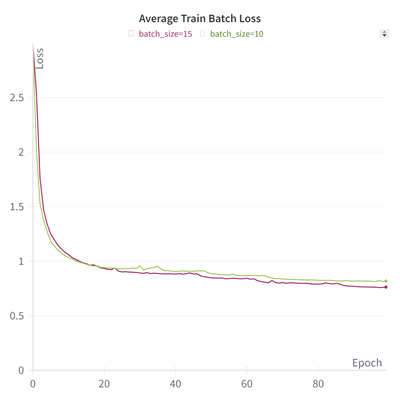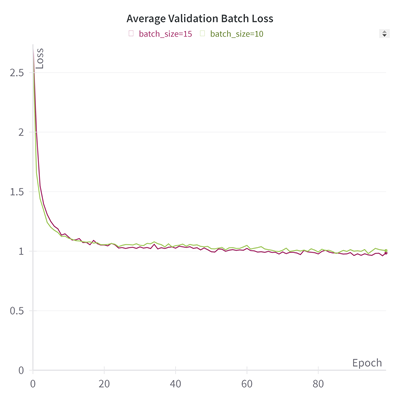

In [ ]:
# Test code
class GreedyCTCDecoder:

    def __init__(self):
        self.text_to_int = {"'": 0, " ": 1, "a": 2, "b": 3, "c": 4,
                            "d": 5, "e": 6, "f": 7, "g": 8, "h": 9,
                            "i": 10, "j": 11, "k": 12, "l": 13, "m": 14,
                            "n": 15, "o": 16, "p": 17, "q": 18, "r": 19,
                            "s": 20, "t": 21, "u": 22, "v": 23, "w": 24,
                            "x": 25, "y": 26, "z": 27}
        self.int_to_text = {v: k for k, v in self.text_to_int.items()}
        self.blank = 28

    def __call__(self, emission, sentence, length):

        # Compute prediction
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i.item() for i in indices if i.item() != self.blank]
        joined = "".join([self.int_to_text[i] for i in indices])

        # Compute actual
        truth = ""
        sentence = sentence.squeeze()
        for i in range(length):
            truth += self.int_to_text[int(sentence[i])]

        return joined, truth


def test(model_name, num_samples=-1):

    test_dataset = LibriSpeechDataset("valid")

    valid_loader = DataLoader(dataset=test_dataset,
                              batch_size=1,
                              shuffle=False,
                              collate_fn=collate,
                              num_workers=3,
                              pin_memory=False)

    # Model
    model = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
    model = model.cuda()
    checkpoint = torch.load(model_name)
    model.load_state_dict(checkpoint)
    model.eval()

    # Output sample predictions
    greedy_decoder = GreedyCTCDecoder()
    wer = WordErrorRate()
    cer = CharErrorRate()
    avg_wer, avg_cer = [], []
    for spectograms, labels, data_lengths, label_lengths in iter(valid_loader):
        if num_samples != -1:
            num_samples -= 1
        if num_samples == -1:
            break
        spectograms, labels = spectograms.cuda(), labels.cuda()
        output, _ = model(spectograms)
        output = F.log_softmax(output, dim=2)
        output = output.squeeze(0)
        predicted = greedy_decoder(output, labels, label_lengths)
        word_error_rate = wer([predicted[0]], [predicted[1]])
        char_error_rate = cer([predicted[0]], [predicted[1]])
        avg_wer += [word_error_rate]
        avg_cer += [char_error_rate]
        if num_samples != -1:
            print("Predicted:", predicted[0])
            print("Actual:", predicted[1])
            print("Word Error Rate:", word_error_rate)
            print("Char Error Rate:", char_error_rate)
            print("_____________________________________")
        # time.sleep(1)

    print("Avg WER:", sum(avg_wer)/len(avg_wer))
    print("Avg CER:", sum(avg_cer)/len(avg_cer))


def test_from_voice(audio_file, ground_truth_text):

    # Load data from file
    data_piece = torchaudio.load(audio_file)[0]
    label_piece = ground_truth_text
    one_dataset = LibriSpeechDataset("one", (data_piece, label_piece))
    loader = DataLoader(dataset=one_dataset, batch_size=1, shuffle=True, collate_fn=collate)

    # Model
    model = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
    model = model.cuda()
    checkpoint = torch.load("best_model_bs10.pth")
    model.load_state_dict(checkpoint)
    model.eval()

    # Output sample predictions
    greedy_decoder = GreedyCTCDecoder()
    wer = WordErrorRate()
    cer = CharErrorRate()
    for spectograms, labels, data_lengths, label_lengths in iter(loader):
        spectograms, labels = spectograms.cuda(), labels.cuda()
        output, _ = model(spectograms)
        output = F.log_softmax(output, dim=2)
        output = output.squeeze(0)
        predicted = greedy_decoder(output, labels, label_lengths)
        word_error_rate = wer([predicted[0]], [predicted[1]])
        char_error_rate = cer([predicted[0]], [predicted[1]])
        print("Predicted:", predicted[0])
        print("Actual:", predicted[1])
        print("Word Error Rate:", word_error_rate)
        print("Char Error Rate:", char_error_rate)
        print("_____________________________________")
        time.sleep(1)

We build two test functions, which are shown above; one for extracting data from our librispeech dataset, and the other for processing and testing on our own audio files. We compute the **word error rate (WER)** and **character error rate (CER)** which are more intuitive metrics for evaluating the performance of our model as opposed to loss. Below, we test it first on 5 examples from our validation dataset, and we additionally test it on our own recorded voices, which act as our test dataset.

In [ ]:
print("Error Rate for BS=10 Model")
print("--------------------------")
test("best_model_bs10.pth", num_samples=15_000)
print("Error Rate for BS=15 Model")
print("--------------------------")
test("best_model_bs15.pth", num_samples=15_000)

In [ ]:
print("##########################")
print("Samples for BS=10 Model")
print("##########################")
test("best_model_bs10.pth", num_samples=5)

In [ ]:
print("##########################")
print("SAMPLES FOR BS=15 Model")
print("##########################")
test("best_model_bs15.pth", num_samples=5)

It appears that the average WER and CER are roughly the same between both models, however, the batch_size=15 model does slightly better. Let's use this model on our test dataset, which is a recording of our voices reading the following sentences:

In [ ]:
audio1_text = "i am looking for a book"
audio2_text = "when setting the table for a meal remember to place the cups spoons" \
              " forks in the correct spot the cups should go at the top right side" \
              " while the spoons and forks are positioned at the side of the plate" \
              " additionally dont forget to include a bottle of water within reach" \
              " for everybody to stay hydrated"
audio3_text = "artificial intelligence or ai is a technology that allows machines to" \
              " learn from data and perform tasks that typically require human intelligence" \
              " this technology is continuously evolving and has the potential to revolutionize" \
              " various industries as ai continues to advance it is important for us to " \
              " understand its capabilities and implications in our society"

test_from_voice("audio1.wav", audio1_text)
test_from_voice("audio2.wav", audio2_text)
test_from_voice("audio3.wav", audio3_text)

Notably the model does appear to do much worse on our own voice, which is expected since we did not explicitly train for this data. While this is true, the predicted words and characters somewhat look similar to the ground truth, although the spelling of the words are very off. The model seems to do better with shorter sentences as well and when we speak slower, so we will aim to do that for our next set of recordings. In order to further improve our model performance, we can do the following things:

1.   **Expand the dataset to include recordings of our own voice.** This will help better generalize to our own voices as opposed to other voices in the librispeech dataset which may not resemble our own.
2.   **More hyperparameter tuning**. It would be interesting to try different sets of hyperparameters and see the impact of other variables like number of residual CNN layers and number of GRU layers and dropout, which can improve our model complexity and help generalize our model better. We will look to achieve this considering we have more time.
3.   **Include WER and CER into the loss function**. This may also be something worthy to try, since our actual test performance is computed based on these metrics. It is possible that model does better if we instead use WER and CER incorporated into the loss function.
4.   **Use a Language Model to improve error rate.** We can use a language model to help with the word error rates as language models can determine how probable a sentence is correct given a reference sentence. This is achieved sin the language models are are built from large corpuses of data so they capture semantic understanding in sentences very well. This way, we can manually correct for spelling mistakes or words that are lost in the context as a post-processing technique without having to spend several days retraining our ASR model.

Overall, we have a strong baseline model that we've trained for our speech to text pipeline and we will aim to do some further fine tuning over the next few weeks.



## **Part 3: What we have left to do and why we will succeed?**

Given our currently trained models, it is evident that we have some strong  results that we will further need to finetune.

1.   **R-CNN:** Regarding the R-CNN, we currently have an RPN model that works decently with the COCO dataset. The model is able successfully predict object bounding boxes and overfit on a small dataset. The next step for this model is to incorporate the object classifier (last part of Faster RCNN), refine the model backbone (feature extractor) and track training/validation loss and accuracies on a larger dataset. We will further finetune the prediction confidence and test the module with image data from a real camera. This will give us a unique testing dataset with which we can verify the true performance of the model.
2.   **Speech to Text:** We have a decently performative model for automatic speech recognition that works with voice data that is not within the dataset. We, however, need to improve the WER and CER of the test dataset as the error still appears to be large. We can do this by the steps detailed at the end of Section 2.
3. **LLM:** We currently have some progress on the LLM pipeline, which was not shown in this document. Our next steps for us will be to integrate the outputs of the R-CNN and Speech to Text module to work with the LLM interface.

Considering we have made significant progress in each element of our pipeline, we believe we will be able to successfully complete the project within the given timeframe. Our next week will be focused on fine tuning our models, and the week after will be integration of our LLM and our presentation.



#Reference

[1] Source: Ren, S. et al. (2016) Faster R-CNN: Towards real-time object detection with region proposal networks, arXiv.org. Available at: https://arxiv.org/abs/1506.01497 (Accessed: 30 March 2024).
